In [3]:
"""
Logistic Regression (probability / log-odds regression) — Beginner -> Advanced
Focus: regression of probabilities (not classification metrics like accuracy).
Covers:
 - IRLS (Newton-Raphson) from scratch (MLE)
 - sklearn LogisticRegression (L2, L1, ElasticNet), solvers and options
 - statsmodels Logit/GLM for deviance/AIC/BIC and summary
 - Cross-validation with neg_log_loss and Brier score
 - Calibration (Isotonic / Platt) and reliability plots
 - Handling separation (regularization), sample weights
 - Regularization path visualization
 - Bayesian logistic (PyMC) optional section
 - Feature engineering: Polynomial / interactions, Pipelines
 - Model persistence
"""

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    log_loss, brier_score_loss,
    mean_squared_error, r2_score
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn import datasets
import joblib
import statsmodels.api as sm
import time


In [4]:
# -----------------------------
# 0. Utility functions
# -----------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def pseudo_r2_deviance(ll_null, ll_model):
    """McFadden's pseudo R^2 based on log-likelihood."""
    return 1 - (ll_model / ll_null)


In [5]:
# -----------------------------
# 1. Data: synthetic (with probability target) + optional CSV loader
# -----------------------------
# Synthetic example: generate features and binary outcomes with true probabilities
np.random.seed(0)
n = 1000
X = np.random.normal(size=(n, 4))
# true coefficients (including intercept)
beta_true = np.array([0.8, -1.2, 0.5, 0.0])
intercept_true = -0.2
logit = intercept_true + X.dot(beta_true)
p = sigmoid(logit)
y = np.random.binomial(1, p, size=n)  # observed outcomes

# Optional: load CSV if you want real data
# df = pd.read_csv("your_file.csv")
# X = df[["col1","col2",...]].values
# y = df["target"].values

# Train-test split (note: keep proportions for probabilities; preserve distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


IRLS: converged: True iters: 5
IRLS coefficients (intercept first): [-0.25102593  0.82143235 -1.08923219  0.46905775  0.04678975]
IRLS training log-likelihood: -432.46429968623346

[IRLS (no reg)] Log-loss (avg): 0.463224, Log-likelihood (sum): -92.644817
[IRLS (no reg)] Brier score: 0.146195, Prob-MSE: 0.146195


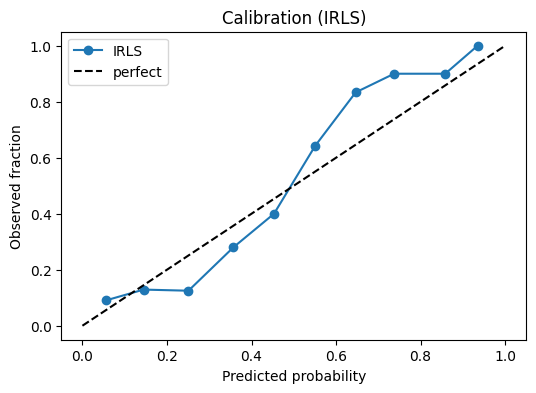

In [6]:
# -----------------------------
# 2. From-scratch IRLS (Newton-Raphson) implementation for logistic MLE
#    - returns beta (including intercept), log-likelihood, convergence info
# -----------------------------
def irls_logistic(X, y, max_iter=100, tol=1e-6, add_intercept=True):
    """
    IRLS (Newton-Raphson) for logistic regression (no regularization).
    X: (n_samples, n_features)
    y: {0,1}
    Returns: beta (p+1), loglikelihood, converged flag, niters
    """
    n, p = X.shape
    if add_intercept:
        X_design = np.hstack([np.ones((n, 1)), X])
    else:
        X_design = X
    beta = np.zeros(X_design.shape[1])
    for i in range(max_iter):
        linear = X_design.dot(beta)
        mu = sigmoid(linear)
        # weight matrix diag of mu*(1-mu)
        W = mu * (1 - mu)
        # check for complete separation -> W small
        # gradient
        grad = X_design.T.dot(y - mu)
        # Hessian = - X^T W X
        # Solve Hessian * delta = grad  (Newton step)
        # But Hessian is negative definite; we compute update via solving (X^T W X) delta = X^T (y-mu)
        XtWX = (X_design * W[:, np.newaxis]).T.dot(X_design)
        # regularize tiny diagonal to avoid singularities
        diag_eps = 1e-8 * np.eye(XtWX.shape[0])
        try:
            delta = np.linalg.solve(XtWX + diag_eps, grad)
        except np.linalg.LinAlgError:
            # fallback: small ridge to stabilize
            delta = np.linalg.solve(XtWX + 1e-4 * np.eye(XtWX.shape[0]), grad)
        beta_new = beta + delta
        if np.max(np.abs(beta_new - beta)) < tol:
            beta = beta_new
            converged = True
            niters = i + 1
            break
        beta = beta_new
    else:
        converged = False
        niters = max_iter
    # log-likelihood
    linear = X_design.dot(beta)
    ll = np.sum(y * linear - np.log1p(np.exp(linear)))
    return beta, ll, converged, niters

# Run IRLS on training data
beta_hat, ll_hat, conv, niters = irls_logistic(X_train, y_train)
print("IRLS: converged:", conv, "iters:", niters)
print("IRLS coefficients (intercept first):", beta_hat)
print("IRLS training log-likelihood:", ll_hat)

# Evaluate predictions (probabilities)
def eval_prob_model(p_pred, y_true, label="model"):
    ll = -log_loss(y_true, p_pred, normalize=False)  # negative log-loss sum -> log-likelihood
    ll_per_sample = -log_loss(y_true, p_pred)
    brier = brier_score_loss(y_true, p_pred)
    mse = mean_squared_error(y_true, p_pred)  # on probability scale
    print(f"\n[{label}] Log-loss (avg): {-ll_per_sample:.6f}, Log-likelihood (sum): {ll:.6f}")
    print(f"[{label}] Brier score: {brier:.6f}, Prob-MSE: {mse:.6f}")

# Predictions for IRLS
if True:
    # prepare design for test
    X_test_design = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
    p_ir = sigmoid(X_test_design.dot(beta_hat))
    eval_prob_model(p_ir, y_test, label="IRLS (no reg)")
    # calibration curve
    prob_true, prob_pred = calibration_curve(y_test, p_ir, n_bins=10)
    plt.figure(figsize=(6,4))
    plt.plot(prob_pred, prob_true, marker='o', label='IRLS')
    plt.plot([0,1],[0,1],'k--', label='perfect')
    plt.xlabel('Predicted probability')
    plt.ylabel('Observed fraction')
    plt.title('Calibration (IRLS)')
    plt.legend()
    plt.show()

In [7]:
# -----------------------------
# 3. statsmodels Logit / GLM for full inference (std errors, AIC/BIC, deviance)
# -----------------------------
X_sm = sm.add_constant(X_train)  # add intercept
logit_model = sm.Logit(y_train, X_sm)
res = logit_model.fit(disp=False, method='newton')
print("\n[statsmodels Logit] summary:\n")
print(res.summary())  # provides coefficients, std err, z, p-values
# log-likelihood, AIC, BIC, deviance
llf = res.llf
ll_null = res.llnull
aic = res.aic
bic = res.bic
print("Log-likelihood:", llf, "Null log-likelihood:", ll_null, "AIC:", aic, "BIC:", bic)
print("McFadden pseudo-R2:", pseudo_r2_deviance(ll_null, llf))

# Evaluate statsmodels probabilities
X_test_sm = sm.add_constant(X_test)
p_sm = res.predict(X_test_sm)
eval_prob_model(p_sm, y_test, label="statsmodels Logit")



[statsmodels Logit] summary:

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      795
Method:                           MLE   Df Model:                            4
Date:                Tue, 02 Sep 2025   Pseudo R-squ.:                  0.2141
Time:                        22:36:18   Log-Likelihood:                -432.46
converged:                       True   LL-Null:                       -550.31
Covariance Type:            nonrobust   LLR p-value:                 7.874e-50
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2510      0.083     -3.007      0.003      -0.415      -0.087
x1             0.8214      0.095      8.666      0.000       0.636       1.007
x2            -1.0892

In [8]:
# -----------------------------
# 4. sklearn LogisticRegression (probability outputs) — Regularized (industry standard)
#    - demonstrate L2 (default), L1, ElasticNet with saga solver
# -----------------------------
# Prepare pipeline with scaling
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=1000, C=1.0))
])
pipe.fit(X_train, y_train)
p_sk = pipe.predict_proba(X_test)[:, 1]
eval_prob_model(p_sk, y_test, label="sklearn LogisticRegression (L2)")

# Show coefficients (on scaled features). To interpret on original scale, back-transform.
coef = pipe.named_steps["clf"].coef_.flatten()
intercept = pipe.named_steps["clf"].intercept_[0]
print("sklearn L2 coef (scaled features):", coef, "intercept:", intercept)

# L1 penalty (sparse coefficients) with saga solver
pipe_l1 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l1", solver="saga", max_iter=5000, C=1.0))
])
pipe_l1.fit(X_train, y_train)
p_l1 = pipe_l1.predict_proba(X_test)[:,1]
eval_prob_model(p_l1, y_test, label="sklearn LogisticRegression (L1)")

# ElasticNet penalty (l1_ratio controls mix) with saga solver
pipe_en = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.5, C=1.0, max_iter=5000))
])
pipe_en.fit(X_train, y_train)
p_en = pipe_en.predict_proba(X_test)[:,1]
eval_prob_model(p_en, y_test, label="sklearn LogisticRegression (ElasticNet)")




[sklearn LogisticRegression (L2)] Log-loss (avg): 0.463961, Log-likelihood (sum): -92.792119
[sklearn LogisticRegression (L2)] Brier score: 0.146515, Prob-MSE: 0.146515
sklearn L2 coef (scaled features): [ 0.79967211 -1.03591524  0.45156135  0.04672607] intercept: -0.288732376716374

[sklearn LogisticRegression (L1)] Log-loss (avg): 0.464053, Log-likelihood (sum): -92.810595
[sklearn LogisticRegression (L1)] Brier score: 0.146562, Prob-MSE: 0.146562

[sklearn LogisticRegression (ElasticNet)] Log-loss (avg): 0.464006, Log-likelihood (sum): -92.801235
[sklearn LogisticRegression (ElasticNet)] Brier score: 0.146538, Prob-MSE: 0.146538


In [9]:
# -----------------------------
# 5. Hyperparameter tuning: tune C (inverse of lambda) and l1_ratio with CV using neg_log_loss
# -----------------------------
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2", "elasticnet"],
    "clf__l1_ratio": [0.0, 0.3, 0.5, 0.7, 0.9]  # ignored for l2 when l1_ratio=0
}
# We need a logistic estimator that accepts l1_ratio param even when penalty='l2' to keep grid simple: custom wrap
from sklearn.base import clone
base = LogisticRegression(solver="saga", max_iter=5000)
pipe_tune = Pipeline([("scaler", StandardScaler()), ("clf", base)])
# Custom grid: apply only allowed combos
grid_params = [
    {"clf__penalty":["l2"], "clf__C":[0.01,0.1,1,10], "clf__l1_ratio":[0.0]},
    {"clf__penalty":["elasticnet"], "clf__C":[0.01,0.1,1,10], "clf__l1_ratio":[0.3,0.5,0.7]}
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
gs = GridSearchCV(pipe_tune, grid_params, scoring="neg_log_loss", cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)
print("\n[GridSearch best params (neg_log_loss)]:", gs.best_params_, "best score:", gs.best_score_)
best_pipe = gs.best_estimator_
p_best = best_pipe.predict_proba(X_test)[:,1]
eval_prob_model(p_best, y_test, label="Best tuned sklearn model")



[GridSearch best params (neg_log_loss)]: {'clf__C': 1, 'clf__l1_ratio': 0.0, 'clf__penalty': 'l2'} best score: -0.5476057202568204

[Best tuned sklearn model] Log-loss (avg): 0.463961, Log-likelihood (sum): -92.792108
[Best tuned sklearn model] Brier score: 0.146514, Prob-MSE: 0.146514


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(



Calibration results:

[Platt (sigmoid) calibrated] Log-loss (avg): 0.464809, Log-likelihood (sum): -92.961748
[Platt (sigmoid) calibrated] Brier score: 0.146923, Prob-MSE: 0.146923

[Isotonic calibrated] Log-loss (avg): 0.462703, Log-likelihood (sum): -92.540639
[Isotonic calibrated] Brier score: 0.146227, Prob-MSE: 0.146227


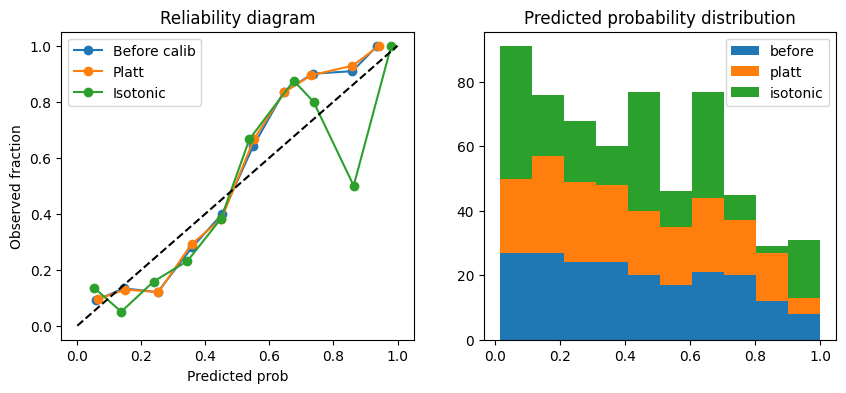

In [10]:
# -----------------------------
# 6. Calibration: isotonic (non-parametric) and sigmoid (Platt) — important when probabilities used directly
# -----------------------------
# CalibratedClassifierCV wraps classifiers to produce better calibrated probabilities
cal_sigmoid = CalibratedClassifierCV(pipe_tune, cv=5, method="sigmoid")
cal_isotonic = CalibratedClassifierCV(pipe_tune, cv=5, method="isotonic")
# Fit on train
cal_sigmoid.fit(X_train, y_train)
cal_isotonic.fit(X_train, y_train)
p_sig = cal_sigmoid.predict_proba(X_test)[:,1]
p_iso = cal_isotonic.predict_proba(X_test)[:,1]

print("\nCalibration results:")
eval_prob_model(p_sig, y_test, label="Platt (sigmoid) calibrated")
eval_prob_model(p_iso, y_test, label="Isotonic calibrated")

# Reliability diagrams
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
prob_true, prob_pred = calibration_curve(y_test, p_best, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Before calib')
prob_true, prob_pred = calibration_curve(y_test, p_sig, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Platt')
prob_true, prob_pred = calibration_curve(y_test, p_iso, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Isotonic')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Predicted prob")
plt.ylabel("Observed fraction")
plt.title("Reliability diagram")
plt.legend()

# Calibration histogram (predicted probability distribution)
plt.subplot(1,2,2)
plt.hist([p_best, p_sig, p_iso], bins=10, label=['before','platt','isotonic'], stacked=True)
plt.title("Predicted probability distribution")
plt.legend()
plt.show()

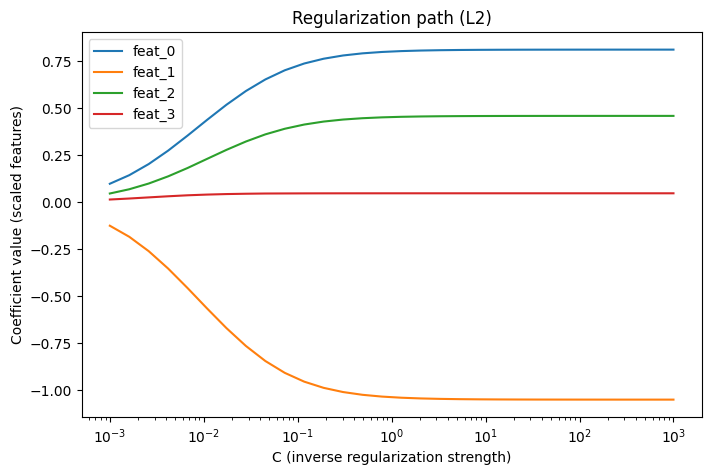

In [11]:
# -----------------------------
# 7. Regularization path exploration (coefficient shrinkage vs C)
# -----------------------------
Cs = np.logspace(-3, 3, 30)
coefs = []
for C in Cs:
    clf = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=2000)
    pipe_tmp = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
    pipe_tmp.fit(X_train, y_train)
    coefs.append(pipe_tmp.named_steps['clf'].coef_.ravel().copy())
coefs = np.array(coefs)
plt.figure(figsize=(8,5))
for k in range(coefs.shape[1]):
    plt.plot(Cs, coefs[:,k], label=f'feat_{k}')
plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Coefficient value (scaled features)')
plt.title('Regularization path (L2)')
plt.legend()
plt.show()


Test log-likelihood: -92.79210781052225 Null log-likelihood: -137.6283942704873
Pseudo-R2 (McFadden) on test: 0.32577787961288174


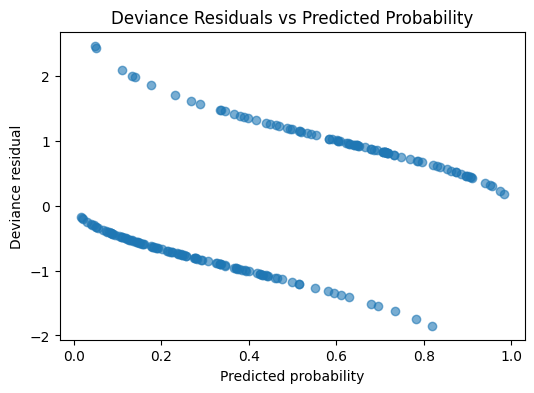

In [12]:

# -----------------------------
# 8. Diagnostics: deviance residuals (approx), pseudo-R2 on test set
# -----------------------------
# approximate log-likelihood for best model on test set
test_ll = -log_loss(y_test, p_best, normalize=False)
null_prob = np.repeat(y_train.mean(), len(y_test))
null_ll = -log_loss(y_test, null_prob, normalize=False)
print("\nTest log-likelihood:", test_ll, "Null log-likelihood:", null_ll)
print("Pseudo-R2 (McFadden) on test:", pseudo_r2_deviance(null_ll, test_ll))

# Deviance residuals: r_i = sign(y_i - p_i) * sqrt( -2*( log p(y_i|p_i) - log p(y_i|y_i) ) )
eps = 1e-15
p_b = np.clip(p_best, eps, 1-eps)
deviance_residuals = np.sign(y_test - p_b) * np.sqrt( -2 * ( y_test * np.log(p_b) + (1-y_test) * np.log(1-p_b) - (y_test * np.log(y_test.clip(eps)) + (1-y_test) * np.log((1-y_test).clip(eps))) ) )
plt.figure(figsize=(6,4))
plt.scatter(p_best, deviance_residuals, alpha=0.6)
plt.xlabel("Predicted probability")
plt.ylabel("Deviance residual")
plt.title("Deviance Residuals vs Predicted Probability")
plt.show()

In [13]:

# -----------------------------
# 9. Handling perfect separation & sample weights
# -----------------------------
# Create a toy separation: if X[:,0]>1 -> y=1 else random; demonstrates regularization necessity
X_sep = X.copy()
y_sep = (X_sep[:,0] > 1).astype(int)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sep, y_sep, test_size=0.2, random_state=0)
# Fit unregularized solver tends to diverge; use regularization (C small)
try:
    clf_sep = LogisticRegression(penalty='none', solver='lbfgs', max_iter=1000)
    clf_sep.fit(X_train_s, y_train_s)
except Exception as e:
    print("\nUnregularized fit failed for separation:", e)
# Regularized fit (works)
clf_sep_reg = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=1000)
clf_sep_reg.fit(X_train_s, y_train_s)
p_sep = clf_sep_reg.predict_proba(X_test_s)[:,1]
print("\nSeparation demo: Brier score with regularization:", brier_score_loss(y_test_s, p_sep))

# Sample weights example (importance sampling)
weights = np.ones_like(y_train)
weights[y_train==1] = 2.0  # upweight positive examples
clf_w = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000)
pipe_w = Pipeline([('scaler',StandardScaler()), ('clf',clf_w)])
pipe_w.fit(X_train, y_train, clf__sample_weight=weights)
p_w = pipe_w.predict_proba(X_test)[:,1]
print("With sample weights - Brier:", brier_score_loss(y_test, p_w))


Unregularized fit failed for separation: The 'penalty' parameter of LogisticRegression must be a str among {'l2', 'elasticnet', 'l1'} or None. Got 'none' instead.

Separation demo: Brier score with regularization: 0.030432046621078106
With sample weights - Brier: 0.16075941178469408


In [14]:
# -----------------------------
# 10. Bayesian logistic regression (PyMC) - optional, runs if available
# -----------------------------
try:
    import pymc as pm
    import arviz as az
    print("\nPyMC found — running a small Bayesian logistic regression (this may take a moment)...")
    t0 = time.time()
    with pm.Model() as blm:
        intercept = pm.Normal("intercept", mu=0, sigma=5)
        coeffs = pm.Normal("coeffs", mu=0, sigma=5, shape=X_train.shape[1])
        logits = intercept + pm.math.dot(X_train, coeffs)
        theta = pm.Deterministic("theta", pm.math.sigmoid(logits))
        y_obs = pm.Bernoulli("y_obs", p=theta, observed=y_train)
        trace = pm.sample(1000, tune=1000, cores=1, chains=2, progressbar=False)
    print("PyMC done. Time:", time.time()-t0)
    summary = az.summary(trace, var_names=["intercept","coeffs"])
    print(summary)
    # Posterior predictive on test
    with blm:
        ppc = pm.sample_posterior_predictive(trace, var_names=["theta"], predictions=False, progressbar=False)
    # ppc['theta'] has shape (n_samples, n_train, n_features?) for our model; to compute predictive probs, use posterior mean on coefficients:
    coeff_mean = trace.posterior["coeffs"].mean(dim=("chain","draw")).values
    intercept_mean = trace.posterior["intercept"].mean(dim=("chain","draw")).values
    p_bay = sigmoid(X_test.dot(coeff_mean) + intercept_mean)
    eval_prob_model(p_bay, y_test, label="PyMC Bayesian logistic (posterior mean)")
except Exception as e:
    print("\nPyMC not available or failed to run. Skipping Bayesian section. Reason:", str(e))



PyMC not available or failed to run. Skipping Bayesian section. Reason: No module named 'pymc'


In [15]:
# -----------------------------
# 11. Save and load best tuned model
# -----------------------------
joblib.dump(best_pipe, "best_logistic_prob_model.joblib")
loaded = joblib.load("best_logistic_prob_model.joblib")
p_loaded = loaded.predict_proba(X_test)[:,1]
print("\nLoaded model Brier:", brier_score_loss(y_test, p_loaded))

# -----------------------------
# Script end: summary of recommended probabilistic metrics (not classification accuracy)
# -----------------------------
print("\nRecommended probabilistic evaluation metrics used above (not classification accuracy):")
print(" - Negative log-likelihood / Log-loss")
print(" - Brier score (mean squared error on probabilities)")
print(" - Calibration / reliability diagram (observed fraction vs predicted prob)")
print(" - Deviance and AIC/BIC (model comparison)")
print(" - Pseudo-R2 (McFadden)")



Loaded model Brier: 0.14651395881031498

Recommended probabilistic evaluation metrics used above (not classification accuracy):
 - Negative log-likelihood / Log-loss
 - Brier score (mean squared error on probabilities)
 - Calibration / reliability diagram (observed fraction vs predicted prob)
 - Deviance and AIC/BIC (model comparison)
 - Pseudo-R2 (McFadden)
